Text(0.5, 1.0, 'Final Output')

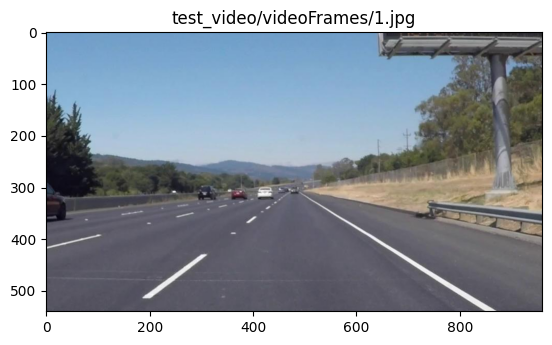

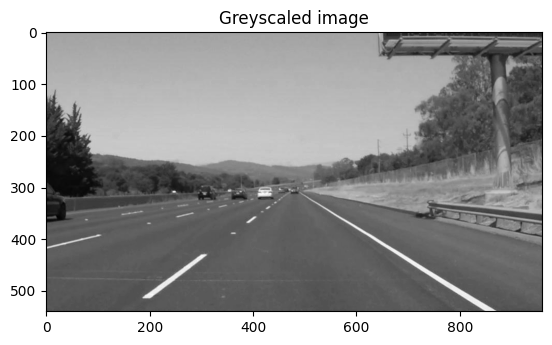

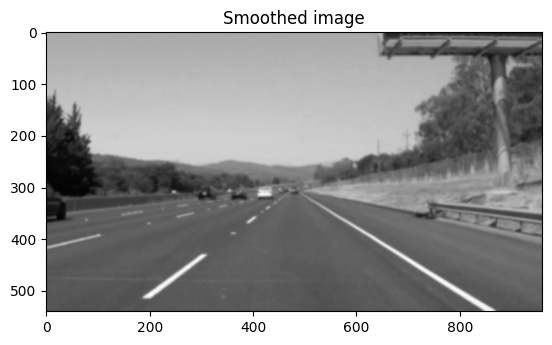

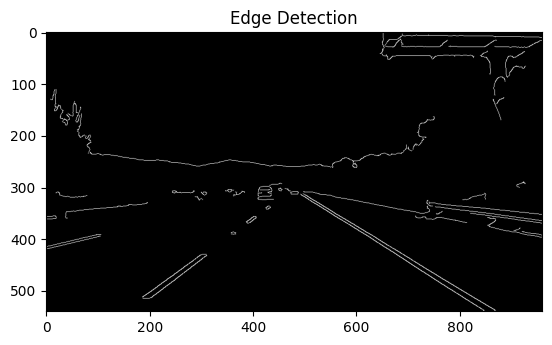

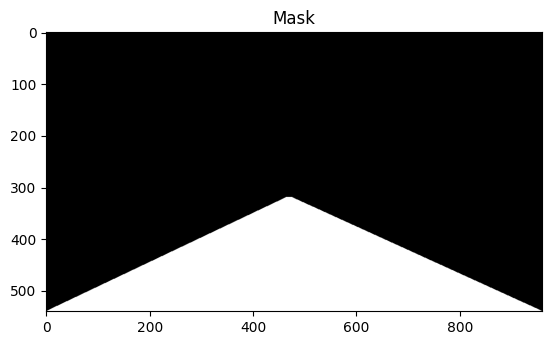

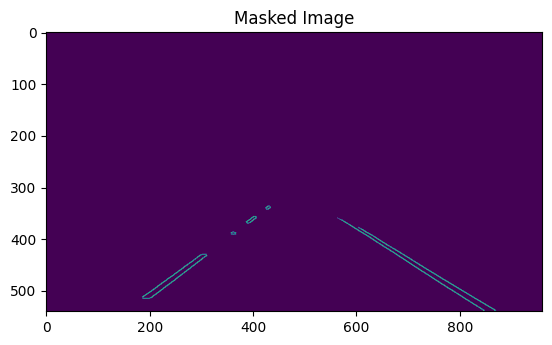

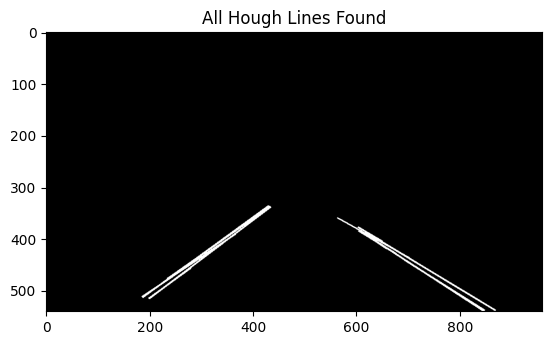

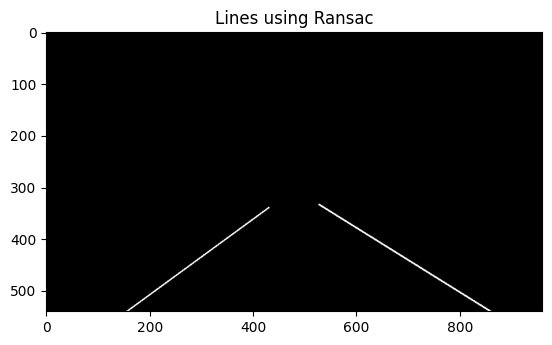

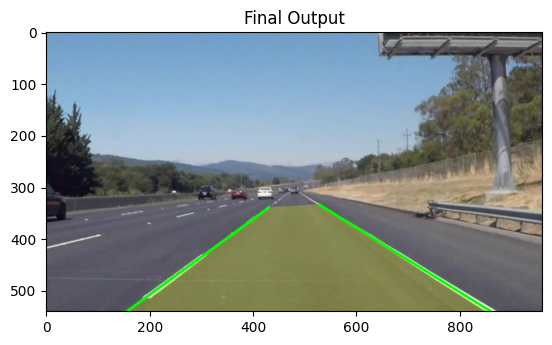

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import os
from sklearn import linear_model

# DETECT LANE FUNCTION
def find_lines(lines):
    slope_min = 0.3
    slope_max = 2
    x_right = []
    y_right = []

    x_left = []
    y_left = []

    for line in lines:
        for x1,y1,x2,y2 in line:
            m = (y2-y1)/(x2-x1)
            if m < -slope_min and m > -slope_max: #left
                if x1 > imshape[1]*0.5 or x2 > imshape[1]*0.5:
                    continue
                else:
                    x_left.append([x1])
                    x_left.append([x2])
                    y_left.append(y1)
                    y_left.append(y2)
            elif m > slope_min and m < slope_max: #right
                if x1 < imshape[1]*0.5 or x2 < imshape[1]*0.5:
                    continue
                else:
                    x_right.append([x1])
                    x_right.append([x2])
                    y_right.append(y1)
                    y_right.append(y2)

    x_right = np.array(x_right)
    y_right = np.array(y_right)
    if not x_right.any() or not y_right.any():
        x1, y1, x2, y2 = int(imshape[1]), int(imshape[0]), int(imshape[1]-0.000001), int(imshape[0]-0.000001)
    else:
        model_ransac_right = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac_right.fit(x_right, y_right)
        line_x_right = np.arange(imshape[1]*0.55, imshape[1]*0.9)
        line_y_right = model_ransac_right.predict(line_x_right[:, np.newaxis])
        x1, y1, x2, y2 = [int(line_x_right[0]), int(line_y_right[0]), int(line_x_right[-1]), int(line_y_right[-1])]

    x_left = np.array(x_left)
    y_left = np.array(y_left)
    if not x_left.any() or not y_left.any():
        x1N, y1N, x2N, y2N = 0, imshape[0], 1, imshape[0]-1
    else:
        model_ransac_left = linear_model.RANSACRegressor(linear_model.LinearRegression())
        model_ransac_left.fit(x_left, y_left)
        line_x_left = np.arange(imshape[1]*0.1, imshape[1]*0.45)
        line_y_left = model_ransac_left.predict(line_x_left[:, np.newaxis])
        x1N, y1N, x2N, y2N = [int(line_x_left[0]), int(line_y_left[0]), int(line_x_left[-1]), int(line_y_left[-1])]

    left = [x1N, y1N, x2N, y2N]
    right = [x1, y1, x2, y2]

    return left, right

# LOAD IMAGE
test_images = [mpimg.imread('image/frames/' + i) for i in os.listdir('image/frames/')]
test_image_names = ['image/frames/'+i for i in os.listdir('image/frames/')]


# GET IMAGE
im = test_images[0]
imshape = im.shape
plt.figure(1)
plt.imshow(im)
plt.title(test_image_names[0])

# GRAY IMAGE
grayIm = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
plt.figure(2)
plt.imshow(grayIm,cmap='gray')
plt.title('Greyscaled image')


# GAUSSIAN FILTER
kernel_size = 9; # bigger kernel = more smoothing
smoothedIm = cv2.GaussianBlur(grayIm, (kernel_size, kernel_size), 0)
plt.figure(3)
plt.imshow(smoothedIm,cmap='gray')
plt.title('Smoothed image')


# EDGE DETECTION 
minVal = 60
maxVal = 150
edgesIm = cv2.Canny(smoothedIm, minVal, maxVal)
plt.figure(4)
plt.imshow(edgesIm,cmap='gray')
plt.title('Edge Detection')


# ROI using TRIZOIDAL
vertices = np.array([[(0,imshape[0]),(465, 320), (475, 320), (imshape[1],imshape[0])]], dtype=np.int32)
mask = np.zeros_like(edgesIm)   
color = 255
cv2.fillPoly(mask, vertices, color)

plt.figure(5)
plt.imshow(mask,cmap='gray')
plt.title('ROI')
    
# APPLY MASK
maskedIm = cv2.bitwise_and(edgesIm, mask)
plt.figure(6)
plt.imshow(maskedIm)
plt.title('Masked Image')


# HOUGH LINES with MASKED IMAGE
rho = 2 # distance resolution in pixels of the Hough grid
theta = np.pi/180 # angular resolution in radians of the Hough grid
threshold = 45     # minimum number of votes (intersections in Hough grid cell)
min_line_len = 40 #minimum number of pixels making up a line
max_line_gap = 100    # maximum gap in pixels between connectable line segments
lines = cv2.HoughLinesP(maskedIm, rho, theta, threshold, np.array([]), 
                            minLineLength=min_line_len, maxLineGap=max_line_gap)



# LINE DETECTION USING RANSAC REGRESSOR
if lines is not None and len(lines) > 2:
    # Draw all lines onto image
    allLines = np.zeros_like(maskedIm)
    for i in range(len(lines)):
        for x1,y1,x2,y2 in lines[i]:
            cv2.line(allLines,(x1,y1),(x2,y2),(255,255,0),2) # plot line


    # Plot all lines found
    plt.figure(7)
    plt.imshow(allLines,cmap='gray')
    plt.title('All Hough Lines Found')

    ransaLines = np.zeros_like(maskedIm)
    left, right = find_lines(lines)
    x1,y1,x2,y2 = right
    x1N, y1N, x2N, y2N = left
    cv2.line(ransaLines,(x1,y1),(x2,y2),(255,255,0),2) # plot line
    cv2.line(ransaLines,(x1N,y1N),(x2N,y2N),(255,255,0),2) # plot line

    plt.figure(8)
    plt.imshow(ransaLines, cmap='gray')
    plt.title('Lines using Ransac')

# FINAL IMAGE
laneFill = im.copy()
vertices = np.array([[(x1,y1),(x2,y2), (x1N,y1N), (x2N,y2N)]], dtype=np.int32)
color = [241,255,1]
cv2.fillPoly(laneFill, vertices, color)
opacity = .25
blendedImg = cv2.addWeighted(laneFill,opacity,im,1-opacity,0,im)
cv2.line(blendedImg,(x1,y1),(x2,y2),(0,255,0),4) # plot line on color image
cv2.line(blendedImg,(x1N,y1N),(x2N,y2N),(0,255,0),4) # plot line on color image

# Plot final output
plt.figure(9)
plt.imshow(blendedImg)
plt.title('Final Output')